# **PROJECT NAME** : PRCP-1001- Rice                                      Leaf Disease Detection
# **PROJECT TEAM ID** :  PTID-CDS-APR-23-1496


# Problem Statement

## Business Case : To classify Rice Leaf Disease using CNN

- Task 1:-Prepare a complete data analysis report on the given data.

- Task 2:-Create a model which can classify the three major attacking diseases of rice plants like leaf blast, bacterial blight and brown spot.

- Task 3:- Analyze various techniques like Data Augmentation, etc and create a report on that.

## Import Basic Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras import models, layers

In [2]:
# Constants
IMAGE_SIZE= 224
BATCH_SIZE= 12
CHANNELS= 3
EPOCHS= 32

## Load the Data

In [3]:
data=tf.keras.preprocessing.image_dataset_from_directory("DATA",
            shuffle=True,
            image_size= (IMAGE_SIZE,IMAGE_SIZE),
            batch_size= BATCH_SIZE)

Found 119 files belonging to 3 classes.


In [4]:
# Types of Classes
class_names= data.class_names
class_names

['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

## Dataset Description

This dataset contains 120 jpg images of disease-infected rice leaves. The images are grouped into 3
classes based on the type of disease. There are 40 images in each class.

Classes

● Leaf smut

● Brown spot

● Bacterial leaf blight

In [5]:
len(data)

10

In [6]:
10*12   # since the batch size we had taken here is 12.

120

In [7]:
# Finding the dimension of images batch and labels batch

for images_batch, labels_batch in data.take(1):
    print(images_batch.shape)
    print(labels_batch.numpy())

(12, 224, 224, 3)
[1 0 0 0 2 0 0 2 1 0 2 2]


In [8]:
# for the first image

for images_batch, labels_batch in data.take(1):  
    print(images_batch[0].numpy())

[[[235.18777 230.18777 224.18777]
  [237.06615 228.06615 223.06615]
  [237.88617 228.88617 223.65848]
  ...
  [239.5549  232.5549  225.55045]
  [238.13184 231.13184 224.86816]
  [237.50223 230.50223 224.50223]]

 [[235.19115 230.19115 224.19115]
  [237.4933  229.5067  224.     ]
  [237.      230.      223.88768]
  ...
  [238.44905 231.44905 223.44905]
  [238.86816 231.86816 225.60449]
  [237.4933  230.4933  224.4933 ]]

 [[235.69556 230.69556 224.69556]
  [238.51115 231.51115 225.51115]
  [238.88617 231.88617 225.88617]
  ...
  [238.      231.      223.     ]
  [238.86816 231.86816 225.60449]
  [237.51115 230.51115 222.51115]]

 ...

 [[236.51117 227.51117 218.51117]
  [237.35713 229.35713 218.35713]
  [236.88617 228.11383 219.     ]
  ...
  [237.43321 230.43321 222.43321]
  [235.      226.      219.     ]
  [236.51117 229.51117 223.51117]]

 [[238.      230.      219.     ]
  [236.8683  229.8683  219.8683 ]
  [236.04425 229.04425 221.04425]
  ...
  [237.11377 230.11377 222.11377]
  [2

In [9]:
# for the first image shape

for images_batch, labels_batch in data.take(1):  
    print(images_batch[0].shape)

(224, 224, 3)


## Data Visualisation

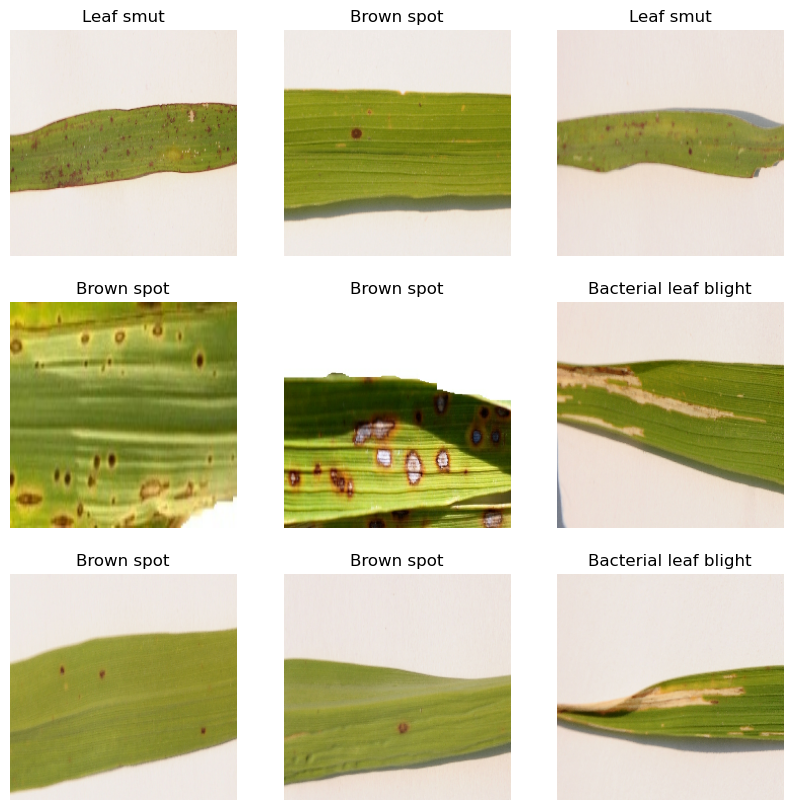

In [10]:
plt.figure(figsize=(10, 10))
for images_batch, labels_batch in data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

## Data Splitting

In [11]:
# Splitting Data into Train Data, Validation Data and Test Data

# 80% ----> for training
# 20% ----> 10% for validation and 10% for testing

## Method I:

In [12]:
len(data)

10

In [13]:
# splitting
train_size= 0.8
len(data)*train_size

8.0

In [14]:
train_ds = data.take(8)
len(train_ds)

8

In [15]:
test_ds = data.skip(8)
len(test_ds)

2

In [16]:
val_size= 0.1
len(data)*val_size

1.0

In [17]:
val_ds = test_ds.take(1)
len(val_ds)

1

In [18]:
test_ds= test_ds.skip(1)
len(test_ds)

1

## Method II:

**We are defining a function to incorporate all the splitting into one single code**

In [19]:
# defining a function for splitting the dataset

def get_data_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=100):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds= ds.shuffle(shuffle_size, seed=100)
        
# For converting it to integer

    train_size = int(train_split * ds_size)   
    val_size = int(val_split * ds_size)
    
    train_ds= ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    
    return train_ds, val_ds, test_ds

In [20]:
# Here, we are splitting the data
train_ds, val_ds, test_ds = get_data_partitions_tf(data)

In [21]:
len(train_ds)

8

In [22]:
len(val_ds)

1

In [23]:
len(test_ds)

1

# Configure the dataset for performance
- **Dataset.cache** keeps the images in memory after they're loaded off disk during the first epoch
- **Dataset.prefetch** overlaps data preprocessing and model execution while training.

In [24]:
train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)

## Resizing and Scaling the Images

In [25]:
#Rescaling and resizing the images properly

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

## Data Augmentation

- **Data augmentation can increase the sample size in the training dataset by techniques like rotation, flipping, zooming etc.**

In [26]:
data_aug = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [27]:
train_ds = train_ds.map(
    lambda x, y: (data_aug(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Model Architecture

In [28]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

## Model Summary

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (12, 224, 224, 3)         0         
                                                                 
 conv2d (Conv2D)             (12, 222, 222, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (12, 111, 111, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (12, 109, 109, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (12, 54, 54, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (12, 52, 52, 64)         

# Compiling the Model
- we use **Adam** optimizer and **tf.keras.losses.SparseCategoricalCrossentropy** loss function. 
To view training and validation accuracy for each training epoch, pass the metrics argument to Model.compile.

In [30]:
from keras import optimizers
optm = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)  # adding learning rate optimization as 0.001
model.compile(optimizer=optm,loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [31]:
# Training

history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
    
)

Epoch 1/32
8/8 [==============================] - 7s 707ms/step - loss: 1.1499 - accuracy: 0.2632 - val_loss: 1.1011 - val_accuracy: 0.3333
Epoch 2/32
8/8 [==============================] - 5s 626ms/step - loss: 1.1008 - accuracy: 0.3053 - val_loss: 1.1029 - val_accuracy: 0.1667
Epoch 3/32
8/8 [==============================] - 5s 628ms/step - loss: 1.0989 - accuracy: 0.3789 - val_loss: 1.1023 - val_accuracy: 0.2500
Epoch 4/32
8/8 [==============================] - 5s 627ms/step - loss: 1.0986 - accuracy: 0.4421 - val_loss: 1.1055 - val_accuracy: 0.1667
Epoch 5/32
8/8 [==============================] - 5s 625ms/step - loss: 1.1001 - accuracy: 0.3684 - val_loss: 1.0993 - val_accuracy: 0.3333
Epoch 6/32
8/8 [==============================] - 5s 624ms/step - loss: 1.0947 - accuracy: 0.4105 - val_loss: 1.1154 - val_accuracy: 0.3333
Epoch 7/32
8/8 [==============================] - 5s 629ms/step - loss: 1.0870 - accuracy: 0.3579 - val_loss: 1.1136 - val_accuracy: 0.1667
Epoch 8/32
8/8 [====

In [32]:
# Performance

scores = model.evaluate(test_ds)

1/1 [==============================] - 1s 525ms/step - loss: 0.5712 - accuracy: 0.9167


In [33]:
history.params

{'verbose': 1, 'epochs': 32, 'steps': 8}

In [34]:
model.evaluate(train_ds)

8/8 [==============================] - 1s 137ms/step - loss: 0.4910 - accuracy: 0.7684


[0.49100005626678467, 0.7684210538864136]

## Insight:

* Here, we got the train accuracy as 76.84% and the test accuracy is 91.67% . So, it is clear that the model is good fitted.

## Plotting the Accuracy and Loss Graph

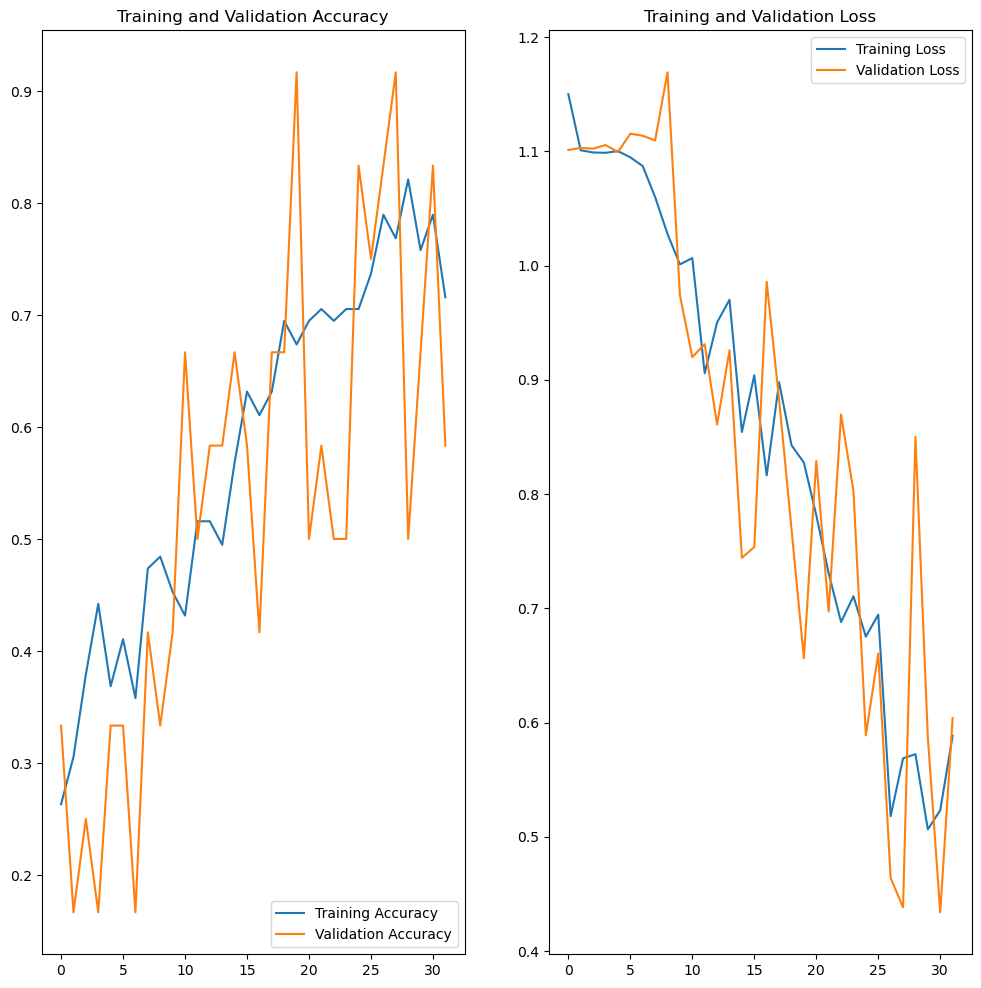

In [35]:
# Plotting the Accuracy and Loss Graph

acc = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Training Accuracy')
plt.plot(epochs_range,val_accuracy,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Training Loss')
plt.plot(epochs_range,val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Inference from the Accuracy and Loss Graph**

From the graph we can see that Accuracy has increased  and
the Loss is decreasing drastically which is a good model

# Predicting

first image to predict
actual label: Brown spot
1/1 [==============================] - 0s 415ms/step
predicted label: Brown spot


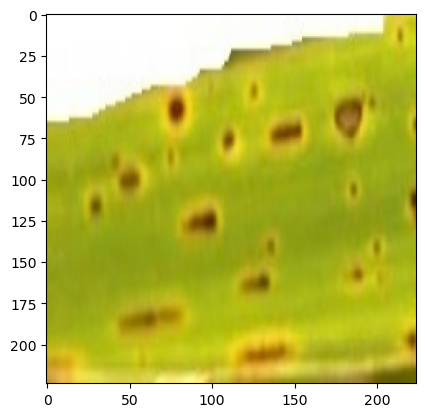

In [36]:
# Run Prediction on sampling image

import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

## Insight:

* Here, we got the actual image and the predicted image as same, which means that the model is working good.

In [37]:
# Function for Inference

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 63ms/step


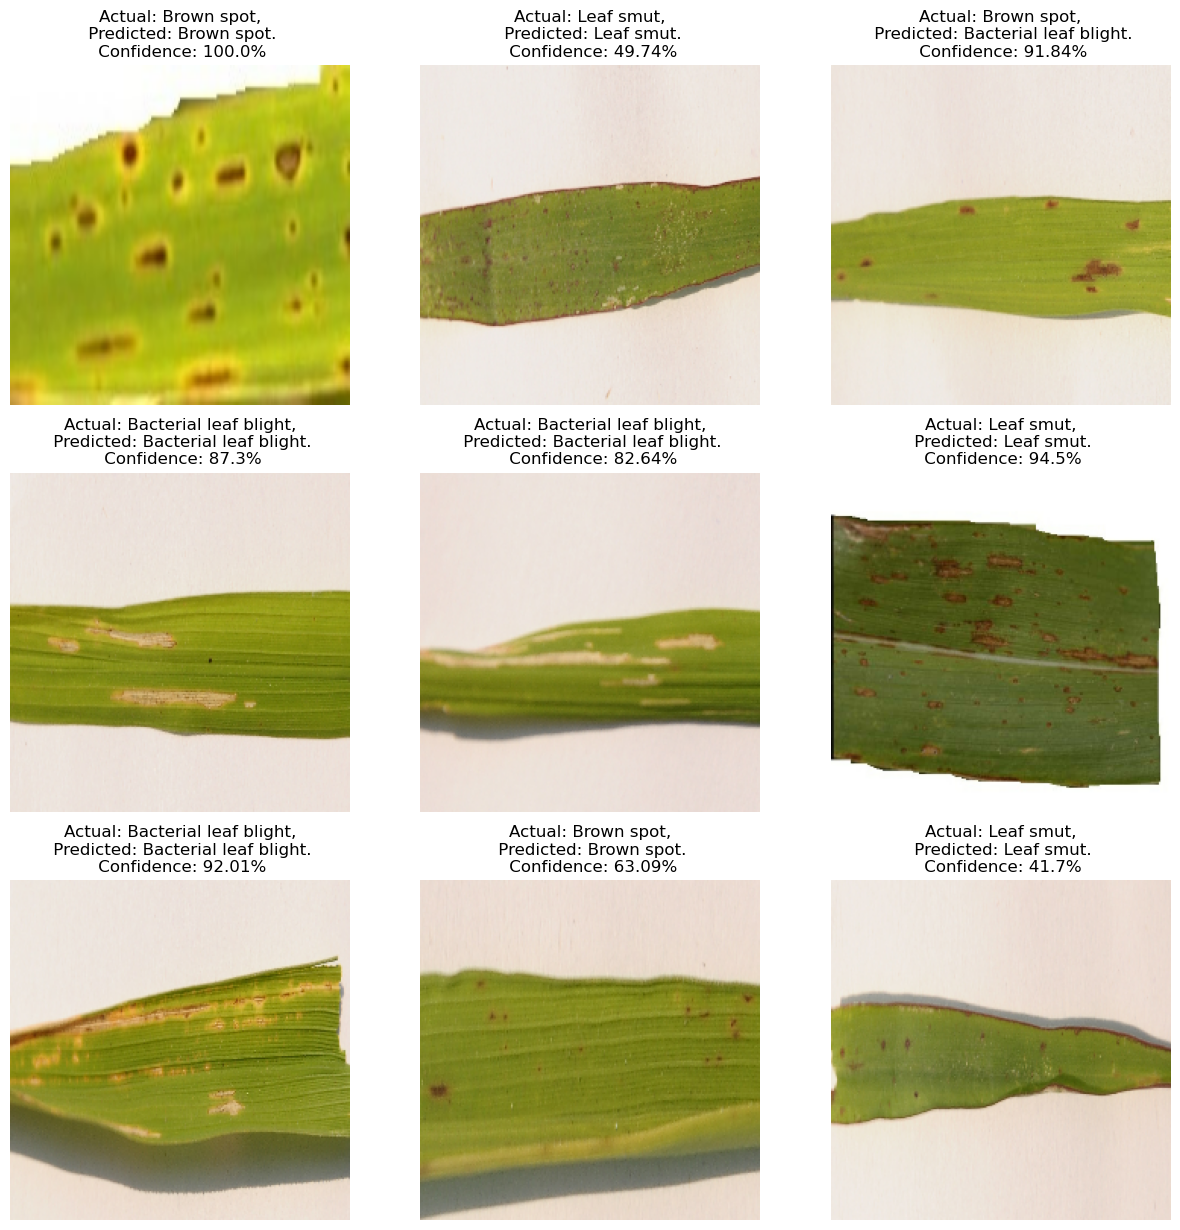

In [38]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# Saving the Model

In [39]:
import os, json, h5py
from datetime import datetime

MODEL_PATH = "models"
MODEL_NAME_FMT = "%Y%m%d_%H%M%S"

if not os.path.exists(MODEL_PATH):
    os.mkdir(MODEL_PATH)

model_version = datetime.now().strftime(MODEL_NAME_FMT)
model_path = f"{MODEL_PATH}/{model_version}.h5"
model.save(model_path)

# writing class_names
with h5py.File(model_path,'r+') as fp:
  fp.attrs['class_names'] = json.dumps(class_names)

# Conclusion:

* **From the above images we can see that almost all the images are classified correctly.**


* **ie; We got all the predictions as almost actual only.**

* **Hence the model created here is good.**